In [1]:
import pandas as pd

from Helpers.PlotHelpers import *
from Helpers.DataHelpers import *
from Helpers.BacktestHelpers import *

from Methods.CopulasHelpers import *
from Methods.DmHelpers import *

In [2]:
# Download data

tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

start_date = pd.to_datetime('2022-01-01') # train 12 months
end_date = pd.to_datetime('2023-07-01') # test 6 months

data = download_data(names, start_date, end_date)

[*********************100%***********************]  65 of 65 completed



6 Failed downloads:
['RE', 'BRK.B', 'PBCT', 'FRC', 'WLTW']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


In [3]:
# Split into train and test data

train_start, train_end = pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31')
test_start, test_end   = pd.to_datetime('2023-01-01'), pd.to_datetime('2023-07-01')

train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)
print(train_data.shape, test_data.shape)

(251, 59) (124, 59)


In [4]:
# Calculate SSD and select 20 pairs with lowest SSD

ssd_train = find_ssd(train_data)
pairs = select_lowest_ssd_pairs(ssd_train, train_data, num_pairs=20)

print(f'Choosen pairs: {len(pairs)} from {round(len(data.columns) * (len(data.columns) - 1) / 2)} posssible pairs')

Choosen pairs: 20 from 1711 posssible pairs


In [5]:
# Find and fit the best fitting distributions to the returns of the selected pairs

# recreate list of pairs just flip 
flipped_pairs = [(pair[1], pair[0]) for pair in pairs]

best_fits = fit_best_distribution_for_pairs(train_data, pairs)
best_fits_flipped_pairs = fit_best_distribution_for_pairs(train_data, flipped_pairs)

In [6]:
# Transform the stock returns to uniform margins using the best fit distributions

uniform_data = transform_to_uniform(train_data, best_fits)
uniform_data_flipped_pairs = transform_to_uniform(train_data, best_fits_flipped_pairs)

# combine uniform data and uniform data flipped pairs they are both dicts
uniform_data = {**uniform_data, **uniform_data_flipped_pairs}

In [7]:
# Fit the best fitting copulas based on BIC to the transformed data

copula_results = fit_best_copulas_to_pairs(uniform_data)

In [8]:
# Get signals

signals = get_trading_signals_copula(test_data, pairs, copula_results, best_fits, threshold=0.8)

                     MCO_SPGI_signal1  MCO_SPGI_positions1  MCO_SPGI_signal2  \
Date                                                                           
2023-01-03 00:00:00                 0                  NaN                 0   
2023-01-04 00:00:00                 0                  0.0                 0   
2023-01-05 00:00:00                 0                  0.0                 0   
2023-01-06 00:00:00                 0                  0.0                 0   
2023-01-09 00:00:00                 0                  0.0                 0   

                     MCO_SPGI_positions2  MCO_SPGI_M1  MCO_SPGI_M2  \
Date                                                                 
2023-01-03 00:00:00                  NaN    -0.027849     0.041981   
2023-01-04 00:00:00                  0.0     0.275178    -0.054254   
2023-01-05 00:00:00                  0.0    -0.105450     0.187872   
2023-01-06 00:00:00                  0.0     0.250716     0.102973   
2023-01-09 00:00:00

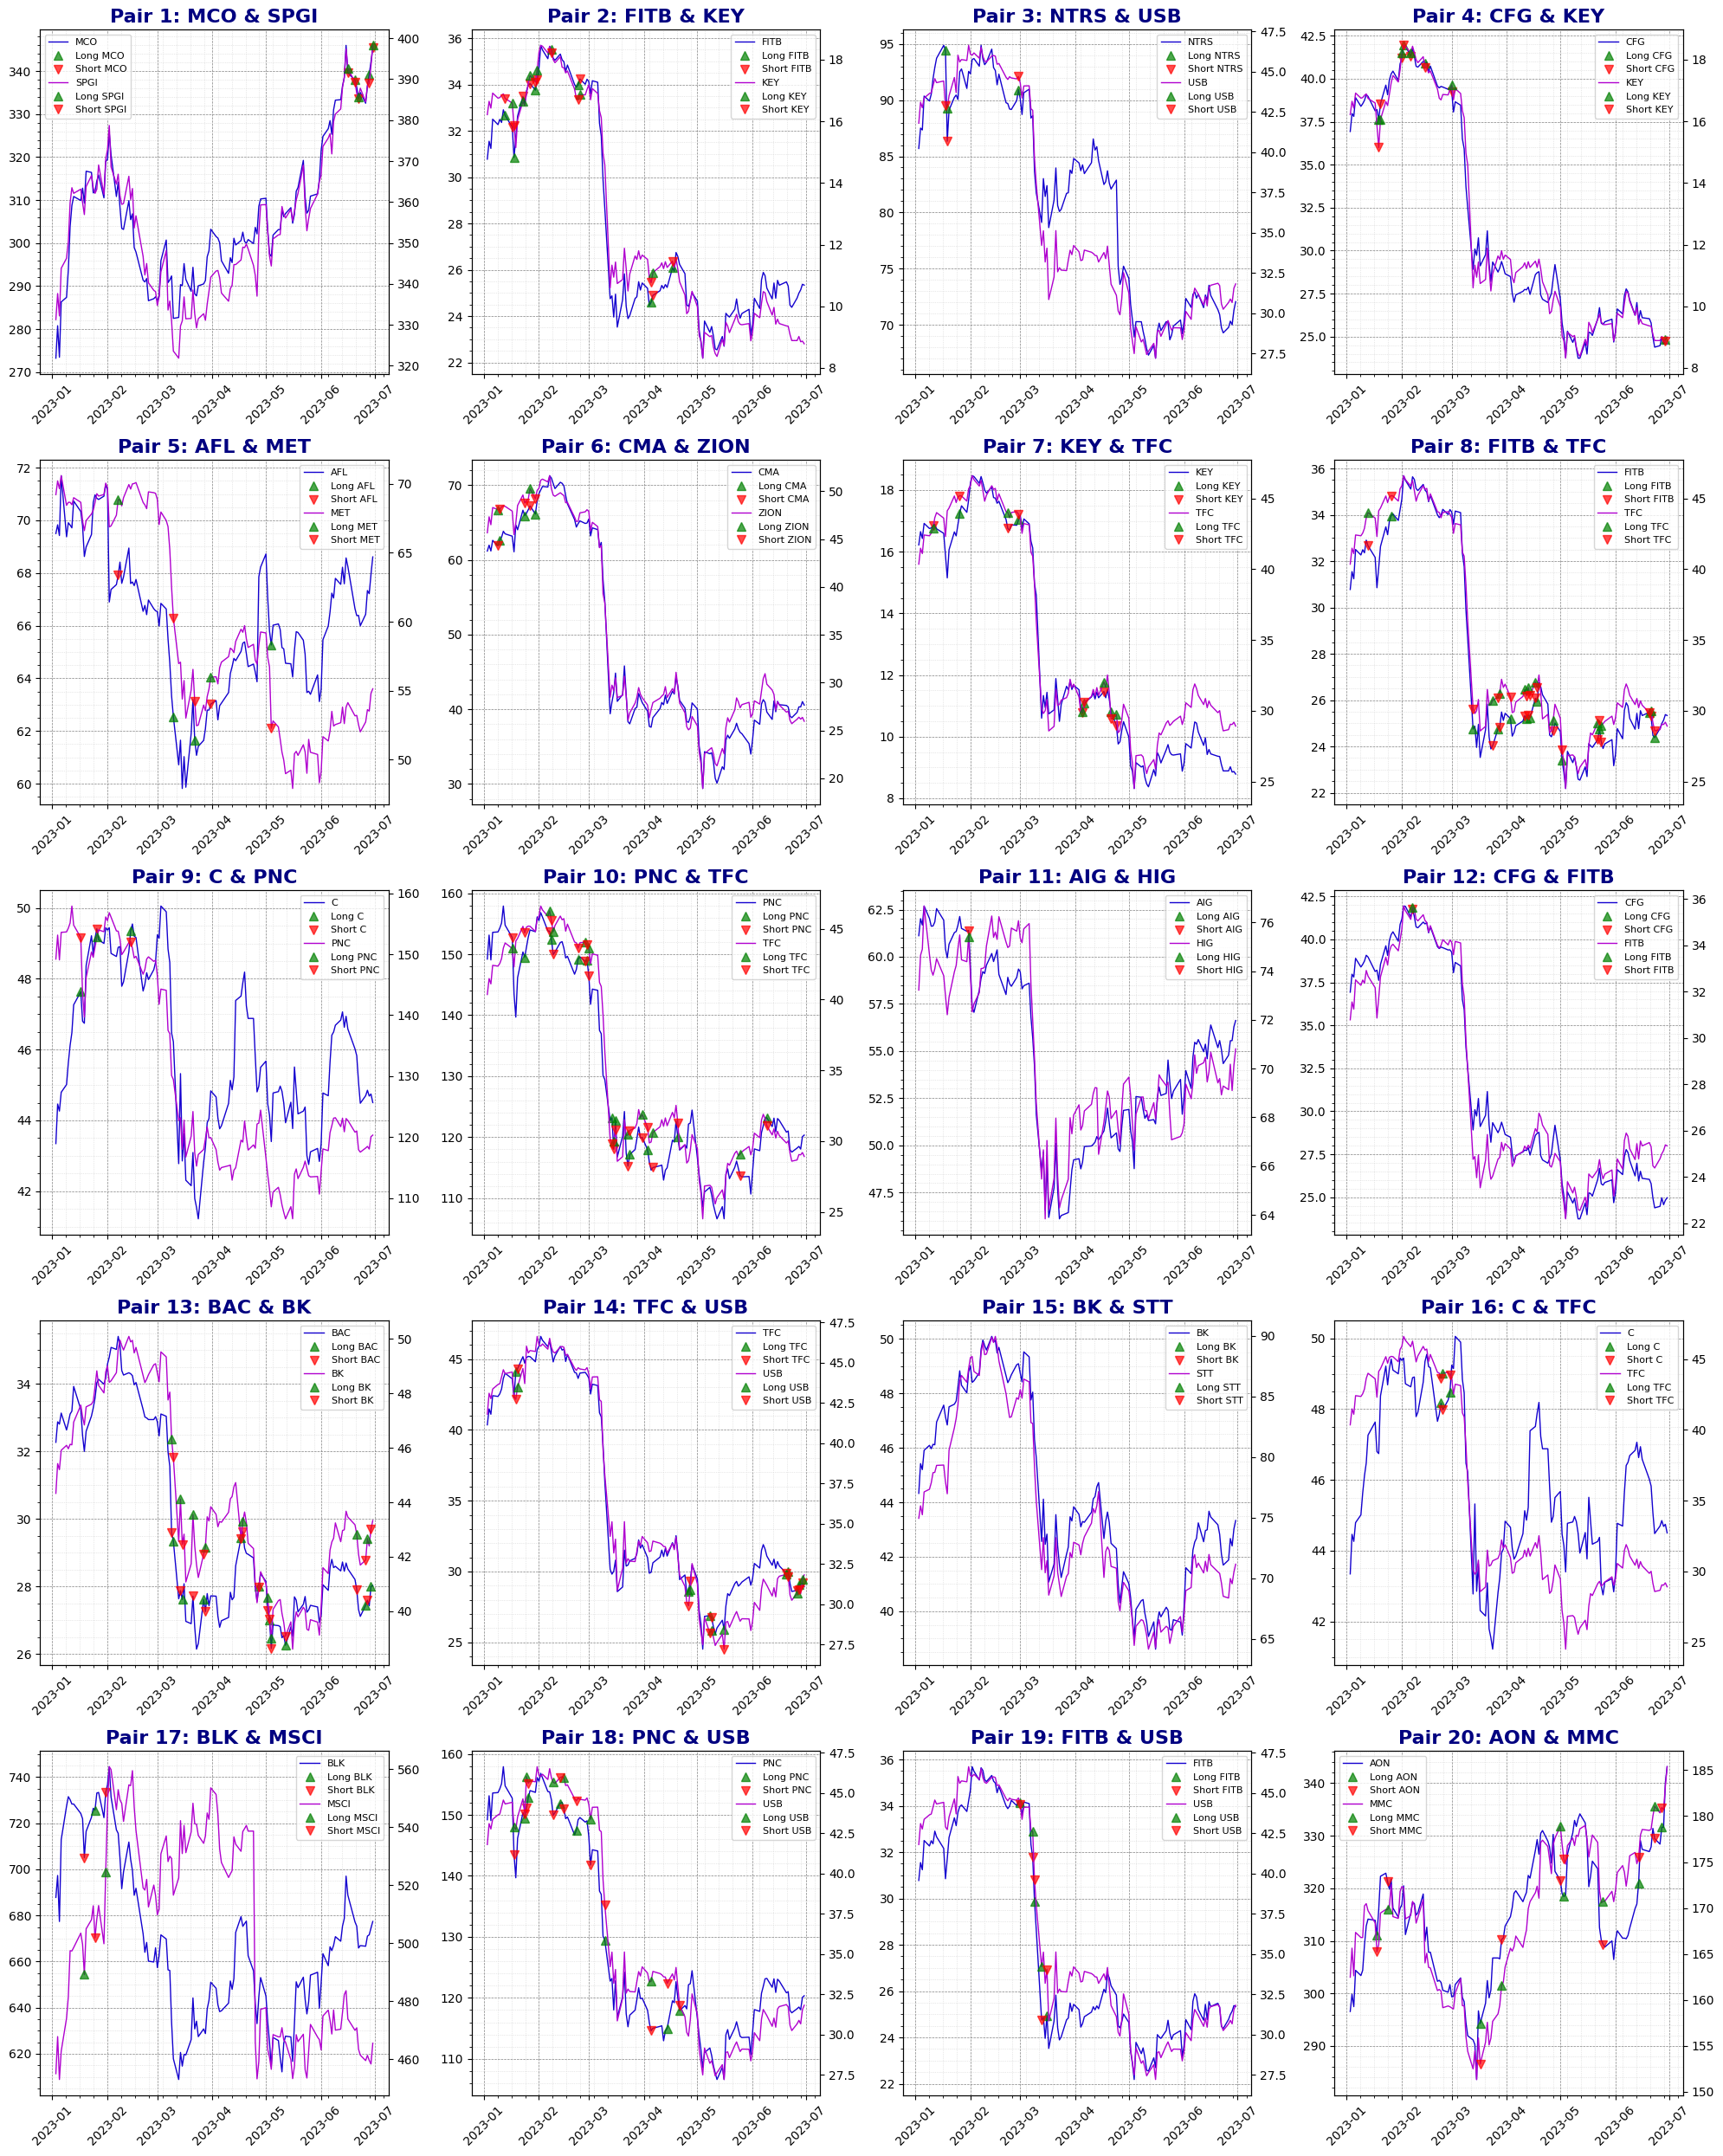

In [9]:
#plot_signals_pairs 

plot_signals_prices_pairs(test_data, signals, pairs)

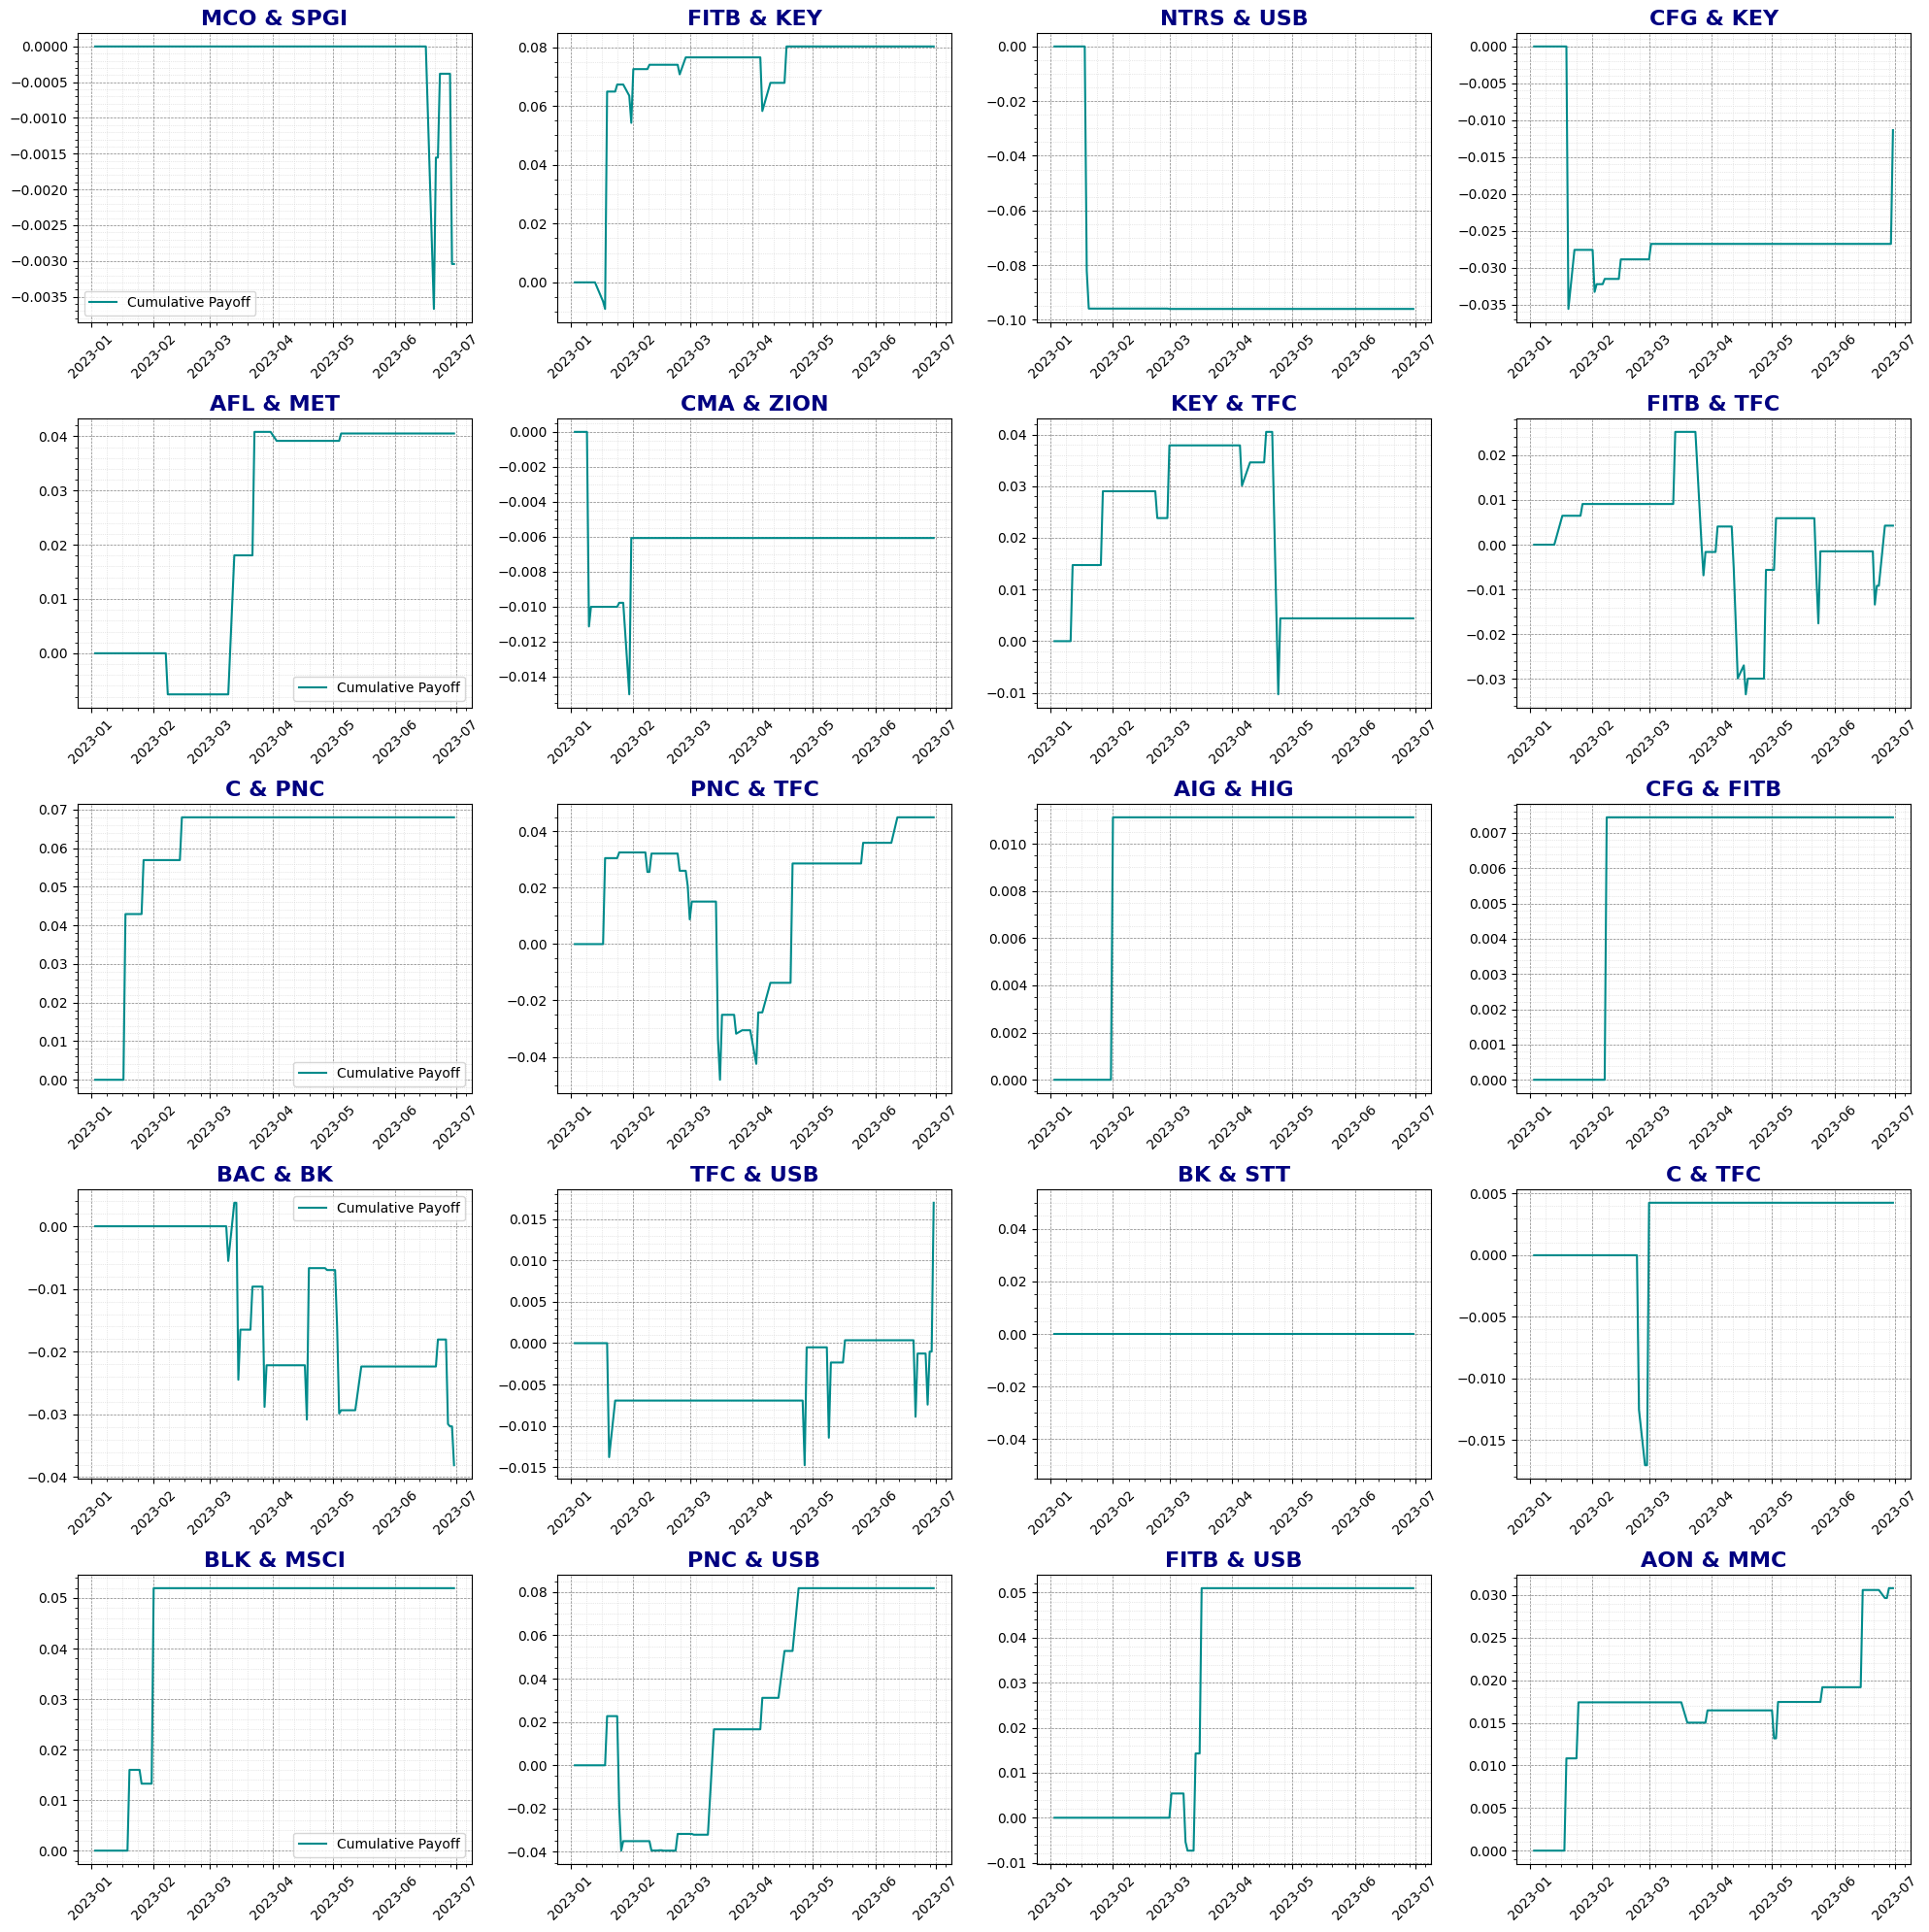

In [10]:
# Plot payoffs of each individual pair

plot_cumulative_payoff_idividual(test_data, signals, pairs)

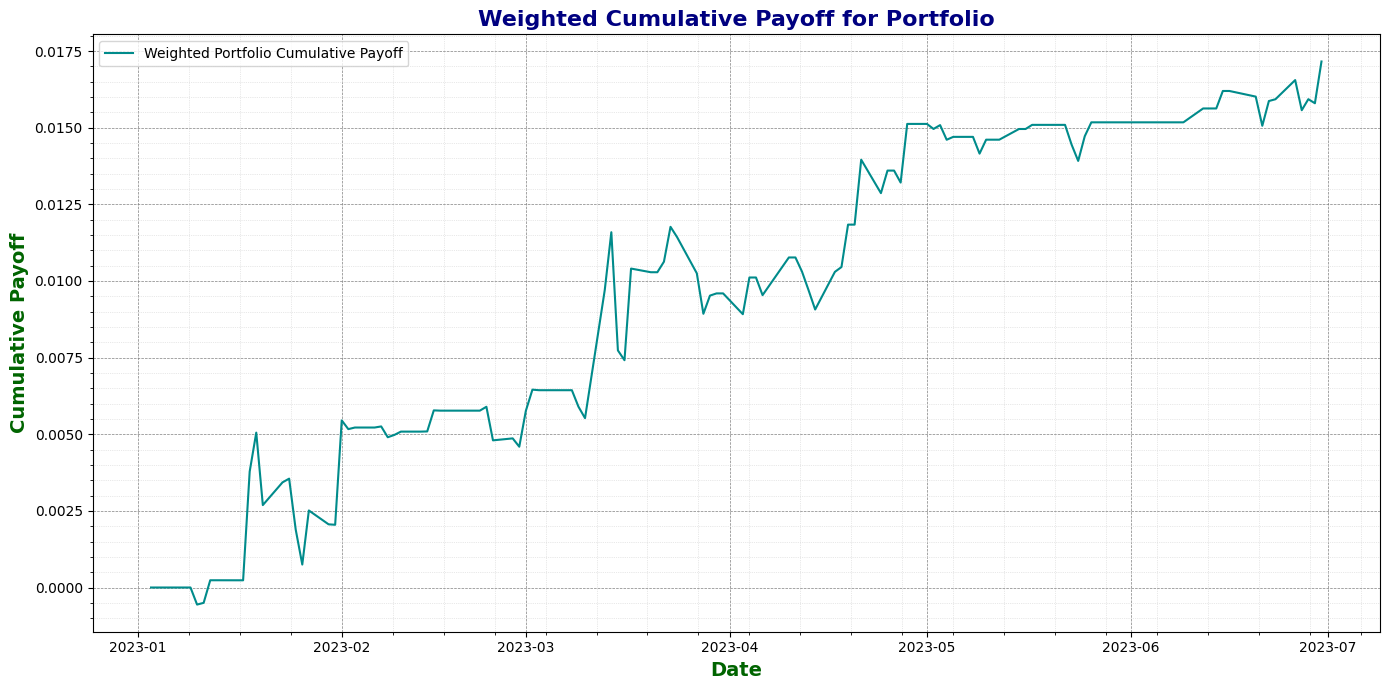

In [11]:
# Plot payoffs of portfolio with equal weights

weights = equal_weighing_scheme(pairs)
plot_cumulative_payoff_portfolio_weighted(test_data, signals, pairs, weights)